In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [2]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [3]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

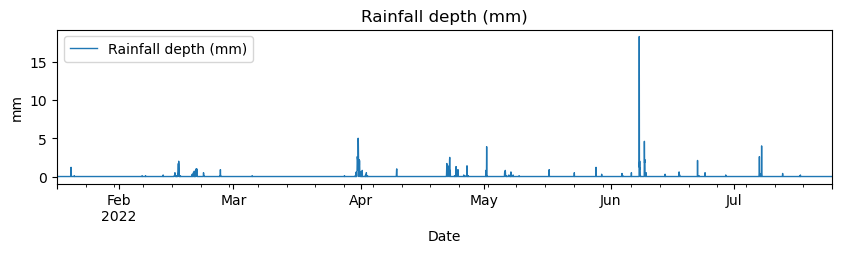

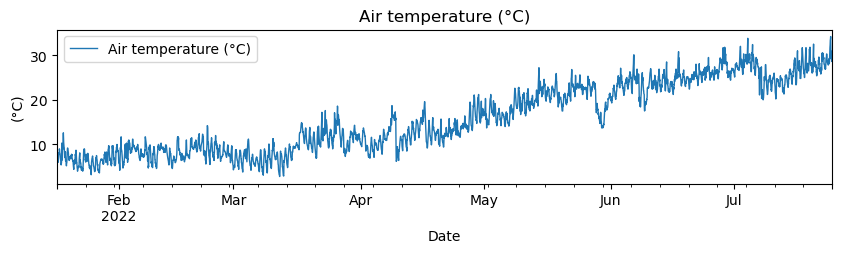

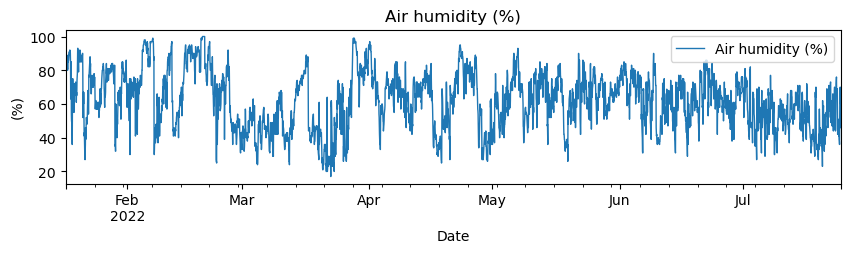

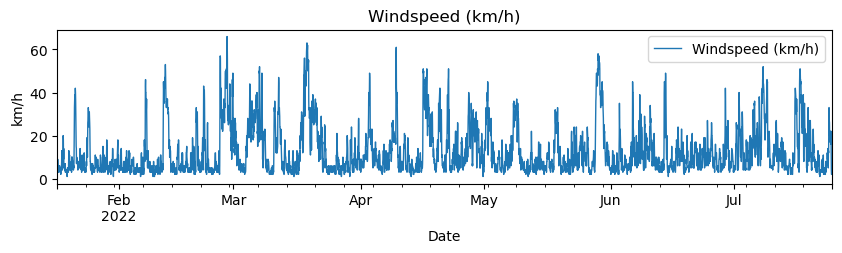

In [4]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-01-17'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

## add weekened and holidays as exogenous variable (one hot encoded)
# tseriesX_df['weekend (0/1)'] = 0
# tseriesX_df[0:24] = 1
# tseriesX_df[144:192] = 1
# tseriesX_df[312:360] = 1

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91769D+00    |proj g|=  1.84934D-01


 This problem is unconstrained.



At iterate    5    f=  1.84147D+00    |proj g|=  2.56906D-01

At iterate   10    f=  1.80001D+00    |proj g|=  2.03996D-01

At iterate   15    f=  1.77875D+00    |proj g|=  8.69197D-02

At iterate   20    f=  1.77774D+00    |proj g|=  1.10807D-02

At iterate   25    f=  1.77664D+00    |proj g|=  3.47083D-02

At iterate   30    f=  1.77642D+00    |proj g|=  1.96106D-02

At iterate   35    f=  1.77467D+00    |proj g|=  5.63285D-02

At iterate   40    f=  1.77239D+00    |proj g|=  3.73798D-02

At iterate   45    f=  1.76828D+00    |proj g|=  3.12318D-02

At iterate   50    f=  1.76621D+00    |proj g|=  9.18626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

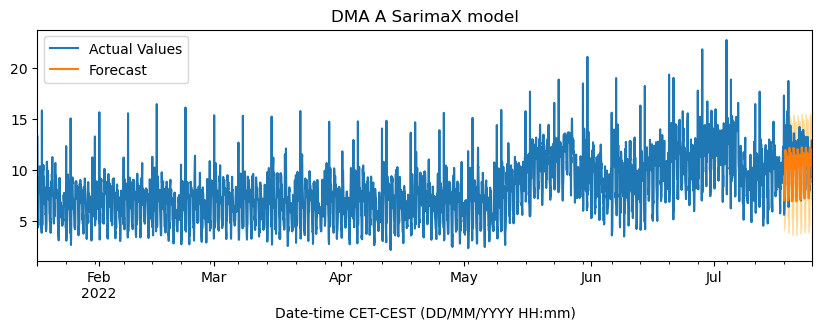

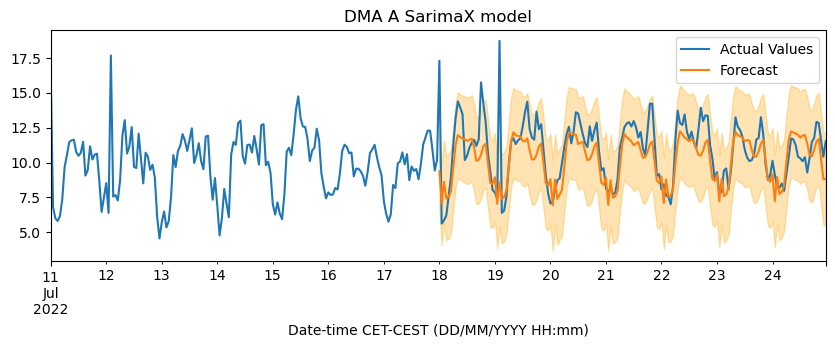

Performance indicators
DMA A Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.77            7.93             1.09           10.79 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.67            9.31             2.96           15.94 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53710D-01    |proj g|=  4.37507D-01


 This problem is unconstrained.



At iterate    5    f=  7.29274D-01    |proj g|=  1.30058D-01

At iterate   10    f=  7.08339D-01    |proj g|=  1.17006D+00

At iterate   15    f=  6.77225D-01    |proj g|=  8.53682D-01

At iterate   20    f=  6.69794D-01    |proj g|=  3.87154D-01

At iterate   25    f=  6.66115D-01    |proj g|=  8.40864D-03

At iterate   30    f=  6.65982D-01    |proj g|=  2.42576D-02

At iterate   35    f=  6.65921D-01    |proj g|=  1.37895D-02

At iterate   40    f=  6.65889D-01    |proj g|=  4.81173D-03

At iterate   45    f=  6.65886D-01    |proj g|=  1.45348D-03

At iterate   50    f=  6.65885D-01    |proj g|=  3.25868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

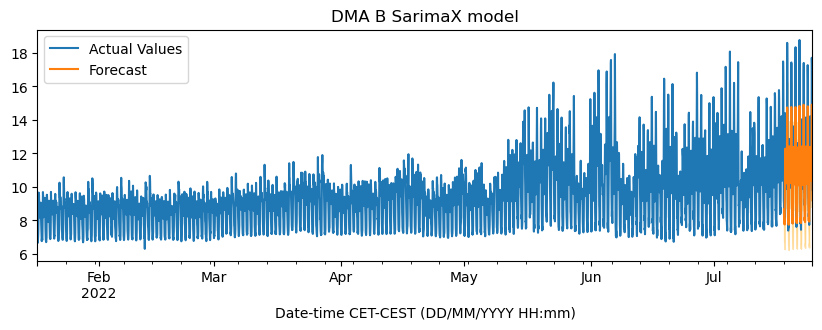

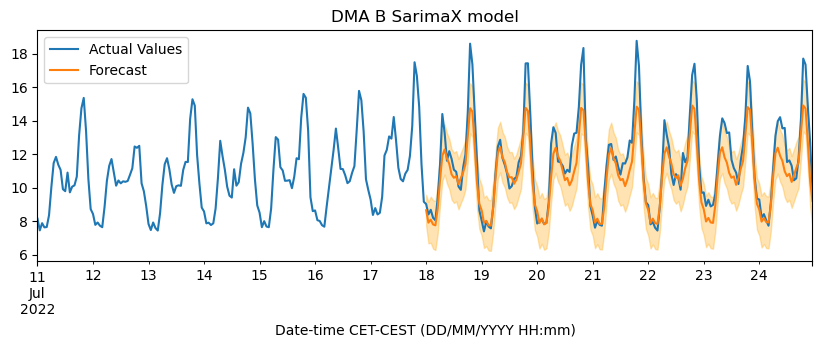

Performance indicators
DMA B Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.97            3.86             0.90           5.73 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.66            9.37             2.76           14.78 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18376D+00    |proj g|=  2.09207D+00


 This problem is unconstrained.



At iterate    5    f=  7.89560D-01    |proj g|=  1.01388D+00

At iterate   10    f=  5.66943D-01    |proj g|=  6.71416D-01

At iterate   15    f=  5.49132D-01    |proj g|=  1.54670D-01

At iterate   20    f=  5.14118D-01    |proj g|=  4.01424D-01

At iterate   25    f=  4.91048D-01    |proj g|=  1.47125D-01

At iterate   30    f=  4.88015D-01    |proj g|=  1.22452D-01

At iterate   35    f=  4.83455D-01    |proj g|=  4.16427D-02

At iterate   40    f=  4.82216D-01    |proj g|=  4.66600D-02

At iterate   45    f=  4.82187D-01    |proj g|=  2.38167D-03

At iterate   50    f=  4.82185D-01    |proj g|=  9.97901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

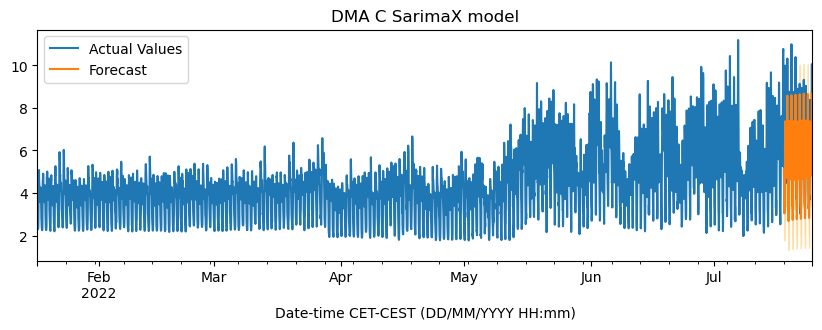

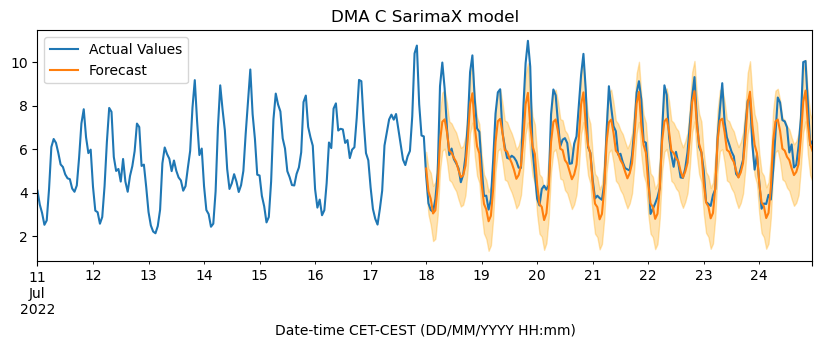

Performance indicators
DMA C Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.74            2.73             0.64           4.11 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.28            6.07             2.07           10.42 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44000D+00    |proj g|=  9.50151D-02


 This problem is unconstrained.



At iterate    5    f=  2.34773D+00    |proj g|=  8.30103D-02

At iterate   10    f=  2.33720D+00    |proj g|=  8.77530D-02

At iterate   15    f=  2.33250D+00    |proj g|=  9.45873D-03

At iterate   20    f=  2.33131D+00    |proj g|=  1.08848D-02

At iterate   25    f=  2.33090D+00    |proj g|=  1.30155D-02

At iterate   30    f=  2.33074D+00    |proj g|=  2.46152D-03

At iterate   35    f=  2.33074D+00    |proj g|=  4.15787D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     37     43      1     0     0   5.829D-05   2.331D+00
  F =   2.3307370840138502     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

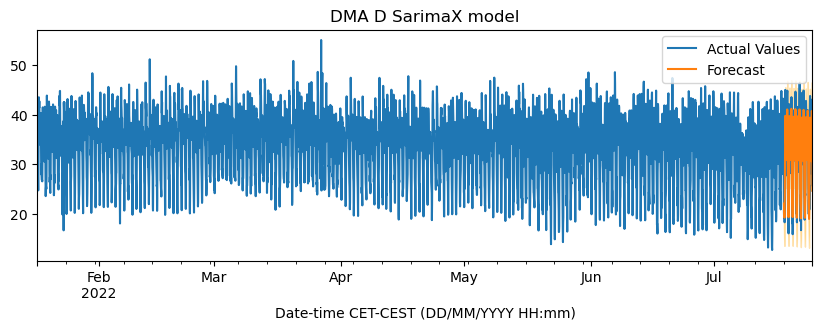

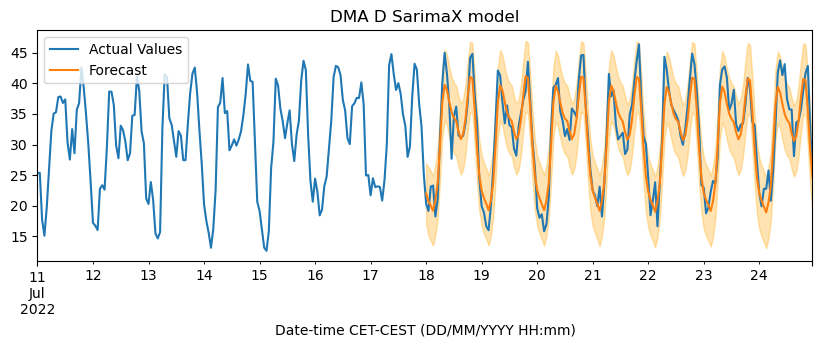

Performance indicators
DMA D Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.32            7.63             2.36           12.30 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.76            14.87             6.45           28.09 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44924D+00    |proj g|=  8.26559D-02


 This problem is unconstrained.



At iterate    5    f=  2.37391D+00    |proj g|=  3.85881D-01

At iterate   10    f=  2.33340D+00    |proj g|=  3.23846D-02

At iterate   15    f=  2.33307D+00    |proj g|=  3.90036D-03

At iterate   20    f=  2.33292D+00    |proj g|=  4.17803D-03

At iterate   25    f=  2.33282D+00    |proj g|=  1.06641D-03

At iterate   30    f=  2.33282D+00    |proj g|=  2.81309D-04

At iterate   35    f=  2.33282D+00    |proj g|=  1.54037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     36     44      1     0     0   7.969D-05   2.333D+00
  F =   2.3328223206231096     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

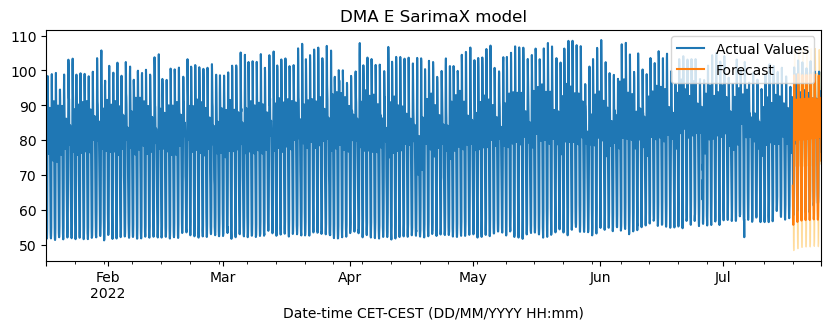

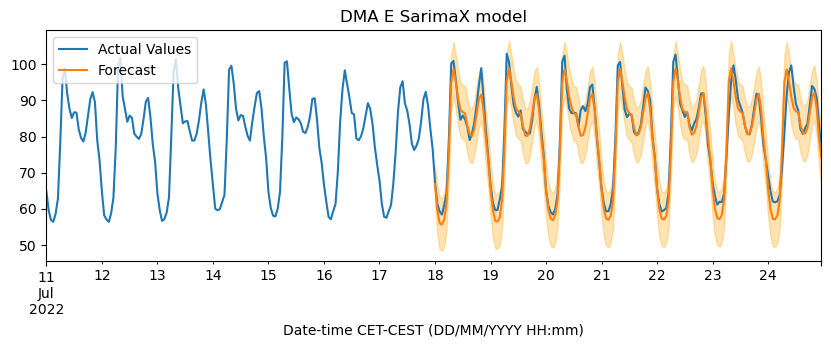

Performance indicators
DMA E Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.41            7.30             2.35           12.06 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
11.66            23.42             11.31           46.39 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53371D+00    |proj g|=  2.55944D-01

At iterate    5    f=  1.48428D+00    |proj g|=  1.01713D-01

At iterate   10    f=  1.45165D+00    |proj g|=  8.10487D-01

At iterate   15    f=  1.44114D+00    |proj g|=  8.44780D-02

At iterate   20    f=  1.43955D+00    |proj g|=  6.68830D-02

At iterate   25    f=  1.43888D+00    |proj g|=  2.21178D-02

At iterate   30    f=  1.43733D+00    |proj g|=  8.24518D-03

At iterate   35    f=  1.43729D+00    |proj g|=  2.80011D-03

At iterate   40    f=  1.43729D+00    |proj g|=  3.04122D-03

At iterate   45    f=  1.43727D+00    |proj g|=  8.46502D-03

At iterate   50    f=  1.43717D+00    |proj g|=  1.87964D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

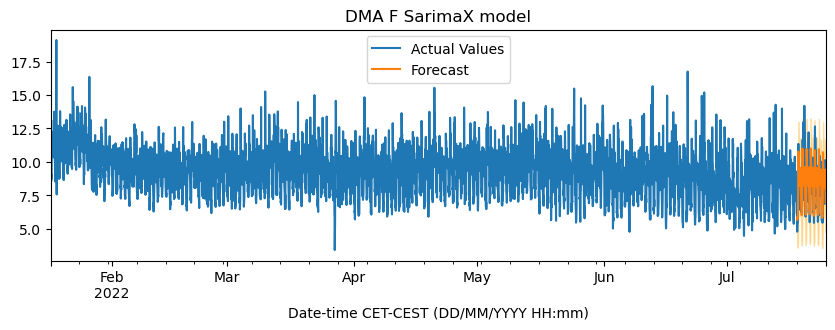

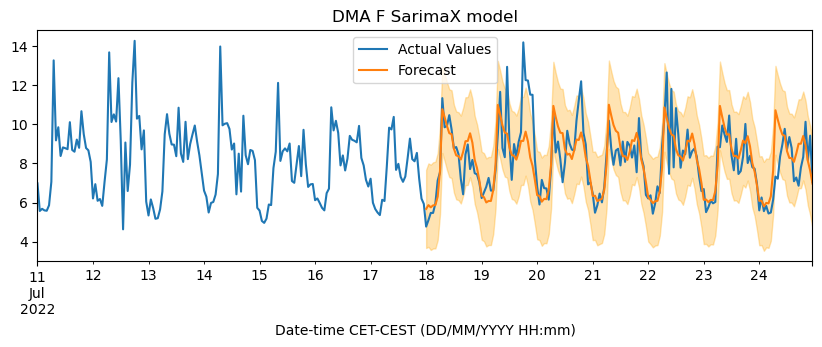

Performance indicators
DMA F Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.58            2.18             0.91           3.67 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.78            4.36             1.61           7.75 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82865D+00    |proj g|=  1.17139D-01

At iterate    5    f=  1.76224D+00    |proj g|=  3.43710D-01

At iterate   10    f=  1.71152D+00    |proj g|=  3.05092D-02

At iterate   15    f=  1.70997D+00    |proj g|=  3.17728D-03

At iterate   20    f=  1.70992D+00    |proj g|=  5.89151D-03

At iterate   25    f=  1.70992D+00    |proj g|=  6.73292D-03

At iterate   30    f=  1.70991D+00    |proj g|=  2.03476D-04

At iterate   35    f=  1.70991D+00    |proj g|=  2.95044D-04

At iterate   40    f=  1.70991D+00    |proj g|=  9.74040D-04

At iterate   45    f=  1.70991D+00    |proj g|=  5.93341D-04

At iterate   50    f=  1.70991D+00    |proj g|=  3.77892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

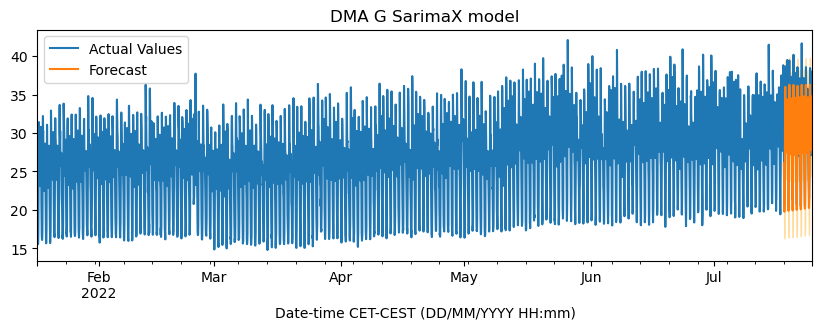

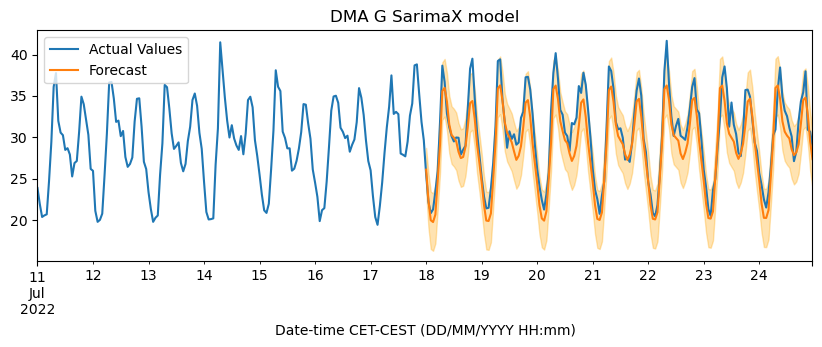

Performance indicators
DMA G Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.50            5.12             1.84           8.46 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
5.47            13.63             5.81           24.91 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06839D+00    |proj g|=  1.33479D+00

At iterate    5    f=  1.61844D+00    |proj g|=  2.10982D-01

At iterate   10    f=  1.53752D+00    |proj g|=  3.27256D-01

At iterate   15    f=  1.48074D+00    |proj g|=  3.51787D-02

At iterate   20    f=  1.46705D+00    |proj g|=  1.57001D-01

At iterate   25    f=  1.46543D+00    |proj g|=  5.84285D-03

At iterate   30    f=  1.46539D+00    |proj g|=  1.86198D-03

At iterate   35    f=  1.46539D+00    |proj g|=  3.86746D-04

At iterate   40    f=  1.46538D+00    |proj g|=  3.38477D-03

At iterate   45    f=  1.46526D+00    |proj g|=  1.47010D-02

At iterate   50    f=  1.46351D+00    |proj g|=  1.31118D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

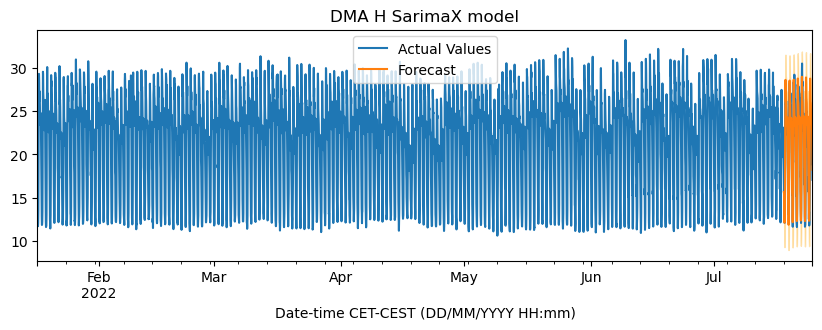

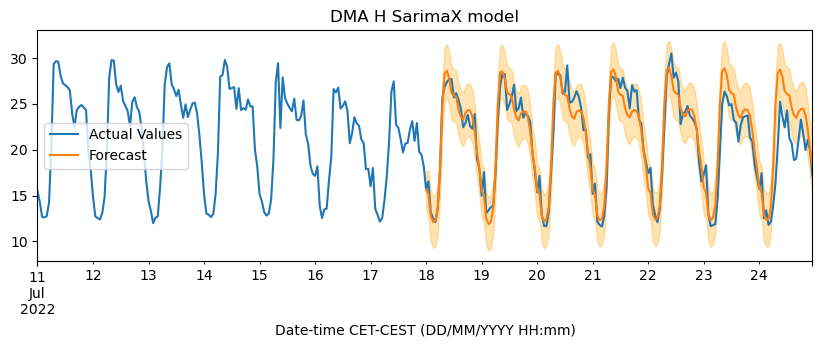

Performance indicators
DMA H Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.77            1.87             1.53           4.16 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.58            9.04             4.52           18.14 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97430D+00    |proj g|=  1.48562D-01


 This problem is unconstrained.



At iterate    5    f=  1.87854D+00    |proj g|=  9.59638D-02

At iterate   10    f=  1.83548D+00    |proj g|=  3.33525D-02

At iterate   15    f=  1.83360D+00    |proj g|=  1.08727D-02

At iterate   20    f=  1.83352D+00    |proj g|=  1.61990D-03

At iterate   25    f=  1.83344D+00    |proj g|=  1.31034D-03

At iterate   30    f=  1.83336D+00    |proj g|=  9.06955D-03

At iterate   35    f=  1.83320D+00    |proj g|=  4.71506D-03

At iterate   40    f=  1.83276D+00    |proj g|=  2.59953D-02

At iterate   45    f=  1.83242D+00    |proj g|=  1.90003D-03

At iterate   50    f=  1.83237D+00    |proj g|=  1.28178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

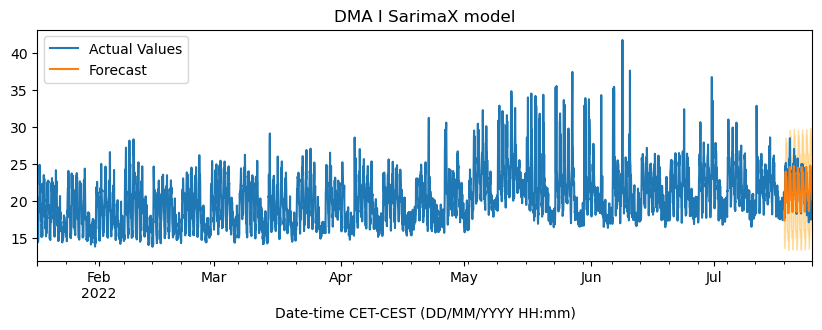

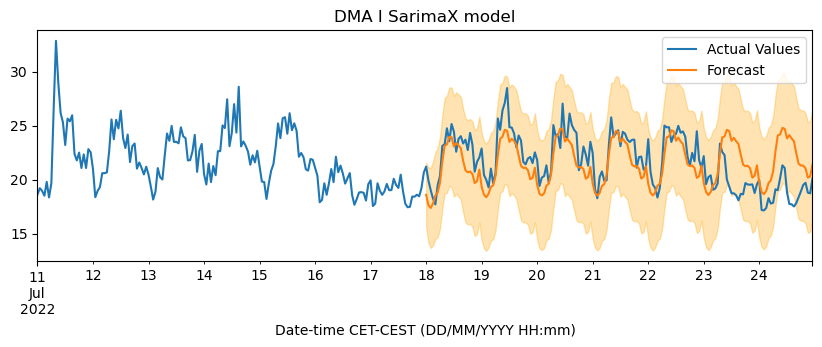

Performance indicators
DMA I Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.44            3.57             1.76           6.77 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.55            4.98             2.28           9.81 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54553D+01    |proj g|=  1.67070D+02


 This problem is unconstrained.



At iterate    5    f=  3.02624D+00    |proj g|=  8.90825D-01

At iterate   10    f=  2.35435D+00    |proj g|=  1.31821D+00

At iterate   15    f=  1.84996D+00    |proj g|=  4.43590D-01

At iterate   20    f=  1.77137D+00    |proj g|=  1.92743D-01

At iterate   25    f=  1.75807D+00    |proj g|=  1.87184D-01

At iterate   30    f=  1.74220D+00    |proj g|=  2.65884D-02

At iterate   35    f=  1.74165D+00    |proj g|=  1.07531D-02

At iterate   40    f=  1.74102D+00    |proj g|=  1.24931D-02

At iterate   45    f=  1.74062D+00    |proj g|=  2.67827D-02

At iterate   50    f=  1.74036D+00    |proj g|=  2.42442D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

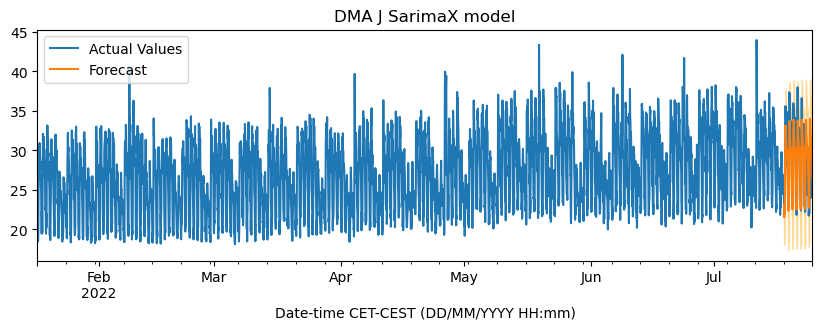

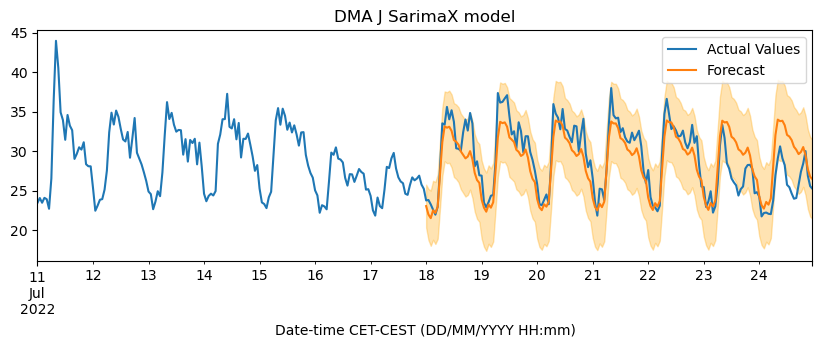

Performance indicators
DMA J Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.77            4.92             2.07           8.76 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.77            8.76             3.93           17.46 



In [5]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # demand time series
    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    # exogenous variables time series
    X = tseriesX_df
    X_train, X_test = temporal_train_test_split(X, test_size=168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.

    model = SARIMAX(y_train, exog=X_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

    # plot forecast and full time series length
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    # plot forecast and last two weeks of time series
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 26-Weeks',return_df=1)
    results_df = pd.concat([results_df, df])
    print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [6]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A Sarima 1-Week,1.772,7.933,1.088,10.793
DMA B Sarima 1-Week,0.970,3.857,0.899,5.726
DMA C Sarima 1-Week,0.740,2.726,0.644,4.110
DMA D Sarima 1-Week,2.317,7.626,2.358,12.301
DMA E Sarima 1-Week,2.412,7.298,2.353,12.062
DMA F Sarima 1-Week,0.582,2.176,0.912,3.671
DMA G Sarima 1-Week,1.502,5.120,1.841,8.462
DMA H Sarima 1-Week,0.766,1.870,1.526,4.162
DMA I Sarima 1-Week,1.438,3.571,1.759,6.768
DMA J Sarima 1-Week,1.769,4.920,2.071,8.760


In [7]:
print(f"{results_df['Total'].sum() :.2f}")

76.81


In [8]:
print(f"{results_df.drop('DMA E Sarima 26-Weeks')['Total'].sum() :.2f}")

64.75
